In [5]:
import Pkg
Pkg.add(["DataFrames", "Distributions", "GLM", "Plots", "StatsPlots", "Random"])


    Updating registry at `C:\Users\diego\.julia\registries\General.toml`
   Resolving package versions...
   Installed OffsetArrays ────── v1.17.0
   Installed StatsPlots ──────── v0.15.8
   Installed Ratios ──────────── v0.4.5
   Installed MultivariateStats ─ v0.10.3
   Installed NearestNeighbors ── v0.4.22
   Installed KernelDensity ───── v0.6.10
   Installed Clustering ──────── v0.15.8
   Installed Arpack_jll ──────── v3.5.1+1
   Installed Interpolations ──── v0.16.2
   Installed AxisAlgorithms ──── v1.1.0
   Installed Widgets ─────────── v0.6.7
   Installed Observables ─────── v0.5.5
   Installed Arpack ──────────── v0.5.4
   Installed WoodburyMatrices ── v1.0.0
    Updating `C:\Users\diego\.julia\environments\v1.11\Project.toml`
  [f3b207a7] + StatsPlots v0.15.8
    Updating `C:\Users\diego\.julia\environments\v1.11\Manifest.toml`
  [7d9fca2a] + Arpack v0.5.4
  [13072b0f] + AxisAlgorithms v1.1.0
  [aaaa29a8] + Clustering v0.15.8
  [a98d9a8b] + Interpolations v0.16.2
  [5ab0869b] +

## Part 1a - Real life examples (2 points)

Un confounder es una variable que afecta tanto al tratamiento como al resultado y si no la controlas, mezcla el efecto verdadero con un back-door path (como la metáfora del perro que se escapa).
Un collider es una variable que es efecto común  de dos variables; si la condicionas o filtras por ella, abres un sesgo y aparece una asociación espuria  entre sus causas.
Un mediator es una variable que está en medio de la ruta causa y transporta parte del efecto; controlarlo entrega el efecto directo  pero corta el efecto indirecto , mientras que no controlarlo da el efecto total.

In [ ]:
# =============== Instalar (una sola vez) ===============
using Pkg
Pkg.add("Luxor")

using Luxor

# Tamaño del lienzo
const W = 800
const H = 500

# Coordenadas de los nodos
const X = Point(120, 400)
const C = Point(400, 120)
const Y = Point(680, 400)

# Estética
const R = 28           # radio de los nodos
const LINEW = 4        # grosor de líneas
const AH_LEN = 20      # largo de la punta de flecha

# Helper: dibuja un nodo circular con etiqueta
function draw_node(pt::Point, label::String)
    sethue("black")
    setline(LINEW)
    circle(pt, R, :stroke)
    setfont("sans", 20)
    textbox(label, pt, 100, 40; halign=:center, valign=:middle)
end

# Helper: flecha entre centros de nodos, “recortando” para no invadir círculos
function arrow_between(a::Point, b::Point; rstart=R+6, rend=R+6)
    v = unitvector(b - a)               # dirección (unitaria) A→B
    p1 = a + v * rstart                 # punto de inicio (fuera del círculo A)
    p2 = b - v * rend                   # punto final (antes del círculo B)
    sethue("black")
    setline(LINEW + 1)
    arrow(p1, p2; arrowheadlength=AH_LEN, arrowsize=1.0)
end

# Dibujo a PNG (también puedes usar @svg si prefieres)
@png begin
    background("white")

    # Nodos
    draw_node(X, "X")
    draw_node(C, "C")
    draw_node(Y, "Y")

    # Flechas: X -> C y Y -> C
    arrow_between(X, C)
    arrow_between(Y, C)
end W H "collider_dag.png"

println("Guardado en collider_dag.png")


    Updating registry at `C:\Users\diego\.julia\registries\General.toml`
   Resolving package versions...
   Installed ImageMagick ───── v1.4.2
   Installed Giflib_jll ────── v5.2.3+0
   Installed ImageMagick_jll ─ v7.1.2005+0
   Installed Media ─────────── v0.5.0
   Installed MappedArrays ──── v0.4.2
   Installed Graphics ──────── v1.1.3
   Installed MosaicViews ───── v0.3.4
   Installed PaddedViews ───── v0.5.12
   Installed libzip_jll ────── v1.11.3+0
   Installed LittleCMS_jll ─── v2.17.0+0
   Installed StackViews ────── v0.1.2
   Installed QuartzImageIO ─── v0.7.5
   Installed OpenJpeg_jll ──── v2.5.4+0
   Installed Cairo ─────────── v1.1.1
   Installed ImageCore ─────── v0.10.5
   Installed libwebp_jll ───── v1.6.0+0
   Installed Juno ──────────── v0.8.4
   Installed Luxor ─────────── v2.7.0
    Updating `C:\Users\diego\.julia\environments\v1.11\Project.toml`
⌃ [ae8d54c2] + Luxor v2.7.0
    Updating `C:\Users\diego\.julia\environments\v1.11\Manifest.toml`
  [159f3aea] + Cairo v1.

## Part 1b - Simpson's paradox (2 points)

La **Paradoja de Simpson** ocurre cuando los datos agregados muestran una relación entre dos variables que se invierte completamente al separar por grupos por ejemplo podríamos encontrar que hacer más ejercicio se asocia con más colesterol, pero esto sería engañoso porque la edad actúa como factor oculto, las personas mayores hacen menos ejercicio y tienen más colesterol naturalmente mientras que los jóvenes hacen más ejercicio y tienen menos colesterol, al mezclar todas las edades se crea una falsa correlación positiva entre ejercicio y colesterol cuando en realidad dentro de cada grupo de edad la relación es negativa, esto demuestra por qué es peligroso sacar conclusiones de datos sin considerar factores que pueden estar influyendo en ambas variables simultáneamente.


In [8]:
using Random, Distributions, DataFrames

Random.seed!(22)

nA = 300
nB = 300

# Parámetros (grupos cercanos, pooled negativo)
slope_within = 0.55
muA, muB     = 3.5, 5.6
sdA, sdB     = 1.2, 1.2
intA, intB   = 7.2, 4.2
noise_sd     = 0.6

# OJO: usa rand(D, n) (no rand.(D, n))
x_A = rand(Normal(muA, sdA), nA)
ε_A = rand(Normal(0, noise_sd), nA)
y_A = slope_within .* x_A .+ intA .+ ε_A

x_B = rand(Normal(muB, sdB), nB)
ε_B = rand(Normal(0, noise_sd), nB)
y_B = slope_within .* x_B .+ intB .+ ε_B

df = DataFrame(
    x     = vcat(x_A, x_B),
    y     = vcat(y_A, y_B),
    group = vcat(fill("A", nA), fill("B", nB))
)
first(df, 5)


Row,x,y,group
,Float64,Float64,String
1,4.74383,9.76045,A
2,5.03995,9.01211,A
3,1.78042,9.16722,A
4,1.52504,7.90566,A
5,3.91602,8.86855,A


Slope A:   0.56  (> 0 esperado)
Slope B:   0.54  (> 0 esperado)
Slope ALL: -0.05  (< 0 esperado)


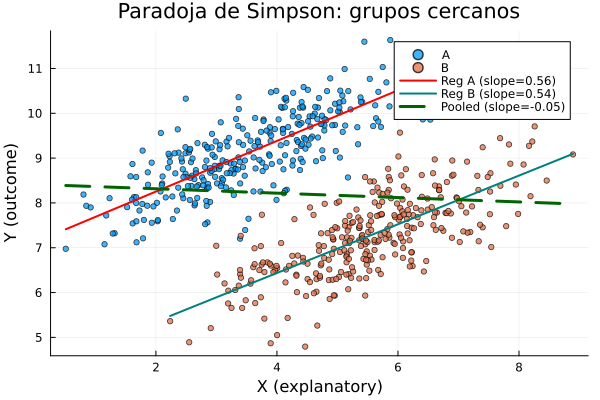

In [ ]:
using GLM, StatsPlots

# Ajustes OLS
lm_A   = lm(@formula(y ~ x), df[df.group .== "A", :])
lm_B   = lm(@formula(y ~ x), df[df.group .== "B", :])
lm_all = lm(@formula(y ~ x), df)

βA  = coef(lm_A)     # [intercepto, slope_x]
βB  = coef(lm_B)
βAll = coef(lm_all)

println("Slope A:   ", round(βA[2], digits=2), "  (> 0 esperado)")
println("Slope B:   ", round(βB[2], digits=2), "  (> 0 esperado)")
println("Slope ALL: ", round(βAll[2], digits=2), "  (< 0 esperado)")

# Dispersión por grupo
default(fmt = :png)  # para notebooks
@df df scatter(:x, :y, group=:group, alpha=0.75, ms=3, legend=:topright,
               xlabel="X (explanatory)", ylabel="Y (outcome)",
               title="Paradoja de Simpson")

# Helper para dibujar líneas
function add_line!(β; xlo, xhi, label="", ls=:solid, lw=2, c=:black)
    xs = range(xlo, xhi, length=200)
    ys = β[1] .+ β[2] .* xs
    plot!(xs, ys, label=label, linestyle=ls, linewidth=lw, color=c)
end

# Rangos por grupo y total
xA = df[df.group .== "A", :x];  xB = df[df.group .== "B", :x]
xloA, xhiA = minimum(xA), maximum(xA)
xloB, xhiB = minimum(xB), maximum(xB)
xlo,  xhi  = minimum(df.x), maximum(df.x)

# Rectas por grupo (estimadas desde los datos)
add_line!(βA;  xlo=xloA, xhi=xhiA,
          label="Reg A (slope=$(round(βA[2], digits=2)))", c=:red)
add_line!(βB;  xlo=xloB, xhi=xhiB,
          label="Reg B (slope=$(round(βB[2], digits=2)))", c=:teal)

# Recta pooled sobre todo el rango
add_line!(βAll; xlo=xlo, xhi=xhi,
          label="Pooled (slope=$(round(βAll[2], digits=2)))",
          ls=:dash, lw=3, c=:darkgreen)
